In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from model import RecommenderNet

In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "C:/Users/trlon/PycharmProjects/pythonProject/recommendation/data/recommendationml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [3]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [5]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


In [6]:
df[["user", "movie"]].values

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ...,
       [ 609, 3121],
       [ 609, 1392],
       [ 609, 2873]], dtype=int64)

In [7]:
X = df[["user", "movie"]].values
# transform input in range 0-1 for fast converge
scaler = MinMaxScaler()
y = scaler.fit_transform(df[["rating"]])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [26]:
y_train

array([[0.33333334],
       [1.        ],
       [0.5555556 ],
       ...,
       [0.7777778 ],
       [0.7777778 ],
       [0.7777778 ]], dtype=float32)

In [23]:
EMBEDDING_SIZE = 50
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [24]:
X_train[:, 0]

array([488,  50, 424, ...,  33, 482, 606], dtype=int64)

In [25]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val),
)

Epoch 1/5
TensorShape([None, 50]) TensorShape([None, 50])


InvalidArgumentError: Graph execution error:

Detected at node 'recommender_net_5/Tensordot/MatMul' defined at (most recent call last):
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\trlon\AppData\Local\Temp\ipykernel_31924\1624231472.py", line 1, in <cell line: 1>
      history = model.fit(
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\trlon\AppData\Local\conda\envs\recommendation\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\trlon\AppData\Local\Temp\ipykernel_31924\4172017950.py", line 36, in call
      dot_user_movie = tf.tensordot(user_vector, movie_vector, 1)
Node: 'recommender_net_5/Tensordot/MatMul'
Matrix size-incompatible: In[0]: [64,50], In[1]: [64,50]
	 [[{{node recommender_net_5/Tensordot/MatMul}}]] [Op:__inference_train_function_101200]

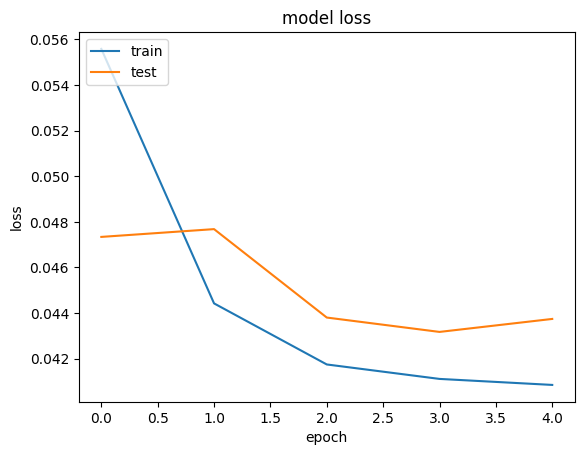

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [46]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
print(user_movie_array)
ratings = model.predict(user_movie_array).flatten()
print(ratings)
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

[[ 228 5804]
 [ 228  481]
 [ 228    1]
 ...
 [ 228 3870]
 [ 228 2989]
 [ 228 7869]]
302/302 [==============================] - 0s 570us/step
[0.63033885 0.60263515 0.566543   ... 0.5714808  0.5753132  0.55790496]
Showing recommendations for user: 229
Movies with high ratings from user
--------------------------------
Toy Story (1995) : Adventure|Animation|Children|Comedy|Fantasy
Babe (1995) : Children|Drama
Braveheart (1995) : Action|Drama|War
Apollo 13 (1995) : Adventure|Drama|IMAX
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Rear Window (1954) : Mystery|Thriller
Casablanca (1942) : Drama|Romance
Reservoir Dogs (1992) : Crime|Mystery|Thriller
One Flew Over the Cuckoo's Nest (1975) : Drama
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Apocalypse Now (1979) :